In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

Data transform convert PIL to tensor format

In [ ]:
data_transformation = transforms.Compose([transforms.ToTensor()])

Download dataset (MNIST) - PIL

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=data_transformation, download=True)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=data_transformation, download=True)

Variables that i need

In [ ]:
img_size = 28
num_channels = 1
patch_size = 7
number_patches = (img_size//patch_size)**2
token_dim = 32
num_heads = 4
transformer_bloks = 4
num_classes = 10
mlp_hidden_dim = 64
learning_rate = 3e-4
epochs = 5
batch_size = 64

Create Batches for nNN training

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

Part 1 of Vit: Patch Embedding

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels, token_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x

Part 2 of ViT: Transformer encoder

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    # layer norm 1
    self.layernorm1 = nn.LayerNorm(token_dim)
    # layre norm 2
    self.layernorm2 = nn.LayerNorm(token_dim)
    # mha
    self.multihead_attention = nn.MultiheadAttention(token_dim, num_heads, batch_first=True)
    # mlp
    self.mlp = nn.Sequential(
        nn.Linear(token_dim, mlp_hidden_dim),
        nn.GELU(),
        nn.Linear(mlp_hidden_dim, token_dim)
    )

  def forward(self, x):

    residual1 = x
    x = self.layernorm1(x)
    x = self.multihead_attention(x, x, x)[0]
    x = residual1 + x

    residual2 = x
    x = self.layernorm2(x)
    x = self.mlp(x)
    x = residual2 + x

    return x

Part 3 of ViT: MLP Classification Head

In [ ]:
class MLPHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm = nn.LayerNorm(token_dim)
    self.mlp_head = nn.Linear(token_dim, num_classes)

  def forward(self, x):
    x = self.layernorm(x)
    x = self.mlp_head(x)

    return x

Part 1,2,3 combined

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1,1,token_dim))
    self.postion_embedding = nn.Parameter(torch.randn(1, number_patches+1, token_dim))
    self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_bloks)])
    self.mlp_head = MLPHead()

  def forward(self, x):
    x = self.patch_embedding(x)
    B = x.shape[0]
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.postion_embedding

    x = self.transformer_blocks(x)
    x = x[:, 0]
    x = self.mlp_head(x)

    return x

Device, model, optimizer, and loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Training Loop

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Epoch 1
  Batch   1: Loss = 2.5183, Accuracy = 14.06%
  Batch 101: Loss = 2.1034, Accuracy = 25.00%
  Batch 201: Loss = 1.0284, Accuracy = 75.00%
  Batch 301: Loss = 0.6164, Accuracy = 84.38%
  Batch 401: Loss = 0.4119, Accuracy = 92.19%
  Batch 501: Loss = 0.2983, Accuracy = 93.75%
  Batch 601: Loss = 0.3008, Accuracy = 90.62%
  Batch 701: Loss = 0.2281, Accuracy = 96.88%
  Batch 801: Loss = 0.2856, Accuracy = 87.50%
  Batch 901: Loss = 0.1533, Accuracy = 96.88%
==> Epoch 1 Summary: Total Loss = 701.0587, Accuracy = 77.82%

Epoch 2
  Batch   1: Loss = 0.1583, Accuracy = 96.88%
  Batch 101: Loss = 0.3324, Accuracy = 84.38%
  Batch 201: Loss = 0.1424, Accuracy = 98.44%
  Batch 301: Loss = 0.3372, Accuracy = 89.06%
  Batch 401: Loss = 0.1364, Accuracy = 93.75%
  Batch 501: Loss = 0.1429, Accuracy = 96.88%
  Batch 601: Loss = 0.1134, Accuracy = 95.31%
  Batch 701: Loss = 0.1967, Accuracy = 92.19%
  Batch 801: Loss = 0.3715, Accuracy = 90.62%
  Batch 901: Loss = 0.2933, Accuracy = 93.75%


Mesaure Accuracy

In [ ]:
# Vision Transformer Class# Switch to evaluation mode
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")


==> Val Accuracy: 96.56%


Visuaizing results

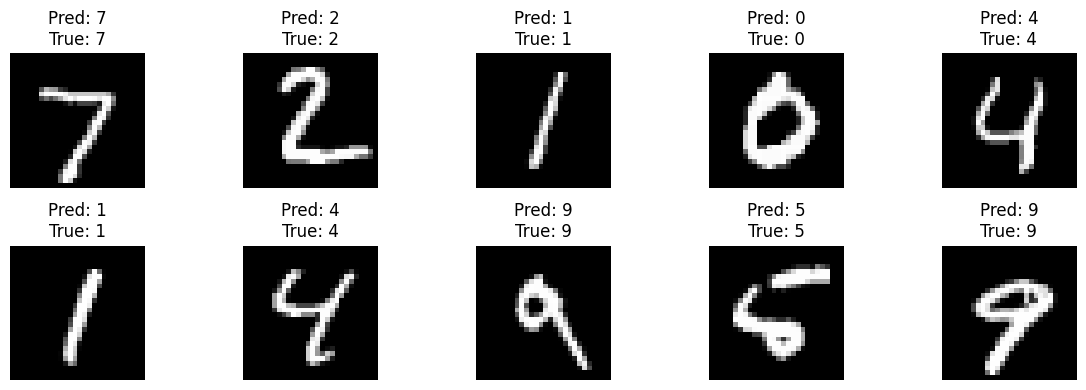

In [ ]:
import matplotlib.pyplot as plt

# Show 10 predictions from the first test batch
model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Move to CPU for plotting
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

# Plot first 10 images
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()